In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torchcp.classification.loss import ConfTr
from torchcp.classification.predictors import SplitPredictor, ClusterPredictor, ClassWisePredictor
from torchcp.classification.scores import THR, APS, SAPS, RAPS, Margin
from torchcp.utils import fix_randomness

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
## dataset

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, pin_memory=True)
cal_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [5000, 5000])
cal_data_loader = torch.utils.data.DataLoader(cal_dataset, batch_size=1600, shuffle=False, pin_memory=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1600, shuffle=False, pin_memory=True)


In [4]:
## model
class Net(nn.Module):
            def __init__(self):
                super(Net, self).__init__()
                self.fc1 = nn.Linear(28 * 28, 500)
                self.fc2 = nn.Linear(500, 10)

            def forward(self, x):
                x = x.view(-1, 28 * 28)
                x = F.relu(self.fc1(x))
                x = self.fc2(x)
                return x

In [5]:
model = Net()
model.to(device)

Net(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [6]:
alpha = 0.1
predictors = [SplitPredictor, ClassWisePredictor, ClusterPredictor]
score_functions = [THR(),  APS(), RAPS(1, 0), SAPS(0.2), Margin()]

In [7]:
def train(model, device, train_loader,criterion,  optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [20]:
predictors_name = ['SplitPredictor', 'ClassWisePredictor', 'ClusterPredictor']

In [21]:
## In Training ##
num_trials = 2
count = 0
result = {}

for class_predictor in predictors:
    result_predictor = {}
    print(predictors_name[count])
    for score in score_functions: 
        print(score.__class__.__name__)
        result_score = {}
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
        predictor = class_predictor(score)
        for loss in ["CE", "ConfTr"]:
            print(loss)
            if loss == "CE":
                criterion = nn.CrossEntropyLoss()
            elif loss == "ConfTr":
                criterion = ConfTr(weight=0.01,
                                predictor=predictor,
                                alpha=0.05,
                                fraction=0.5,
                                loss_type="valid",
                                base_loss_fn=nn.CrossEntropyLoss())
            else:
                raise NotImplementedError
            
            result_loss = {}
    
            for seed in range(num_trials):
                fix_randomness(seed=seed)
                for epoch in range(1, 10):
                    train(model, device, train_data_loader, criterion, optimizer, epoch)
                    predictor = class_predictor(score, model)
                    predictor.calibrate(cal_data_loader, alpha)                
                    tmp_res = predictor.evaluate(test_data_loader)
                    result_loss['Coverage_rate'] = tmp_res['Coverage_rate'] / num_trials
                    result_loss['Average_size'] = tmp_res['Average_size'] / num_trials

            result_score[loss] = result_loss

        result_predictor[score.__class__.__name__] = result_score
    
    result[predictors_name[count]] = result_predictor
    count = count + 1

print(result)

SplitPredictor
THR
CE
ConfTr
APS
CE
ConfTr
RAPS
CE
ConfTr
SAPS
CE
ConfTr
Margin
CE
ConfTr
ClassWisePredictor
THR
CE
ConfTr


/usr/local/lib/python3.10/dist-packages/torchcp/classification/predictors/split.py:67: UserWarning: The value of quantile exceeds 1. It should be a value in (0,1). To avoid program crash, the threshold is set as torch.inf.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchcp/classification/predictors/split.py:61: UserWarning: The number of scores is 0, which is a invalid scores. To avoid program crash, the threshold is set as torch.inf.
  warnings.warn(


APS
CE
ConfTr
RAPS
CE
ConfTr
SAPS
CE
ConfTr
Margin
CE
ConfTr
ClusterPredictor
THR
CE
ConfTr
APS
CE
ConfTr
RAPS
CE
ConfTr
SAPS
CE
ConfTr
Margin
CE
ConfTr
{'SplitPredictor': {'THR': {'CE': {'Coverage_rate': 0.4472, 'Average_size': 0.4555}, 'ConfTr': {'Coverage_rate': 0.4502, 'Average_size': 0.4542}}, 'APS': {'CE': {'Coverage_rate': 0.4463, 'Average_size': 0.496}, 'ConfTr': {'Coverage_rate': 0.455, 'Average_size': 0.5034}}, 'RAPS': {'CE': {'Coverage_rate': 0.4475, 'Average_size': 0.4585}, 'ConfTr': {'Coverage_rate': 0.4539, 'Average_size': 0.4642}}, 'SAPS': {'CE': {'Coverage_rate': 0.4476, 'Average_size': 0.4816}, 'ConfTr': {'Coverage_rate': 0.4542, 'Average_size': 0.4872}}, 'Margin': {'CE': {'Coverage_rate': 0.0003, 'Average_size': 0.004}, 'ConfTr': {'Coverage_rate': 0.0003, 'Average_size': 0.004}}}, 'ClassWisePredictor': {'THR': {'CE': {'Coverage_rate': 0.4496, 'Average_size': 0.4502}, 'ConfTr': {'Coverage_rate': 0.4492, 'Average_size': 0.4497}}, 'APS': {'CE': {'Coverage_rate': 0.4543, 

In [30]:
data = result.copy()

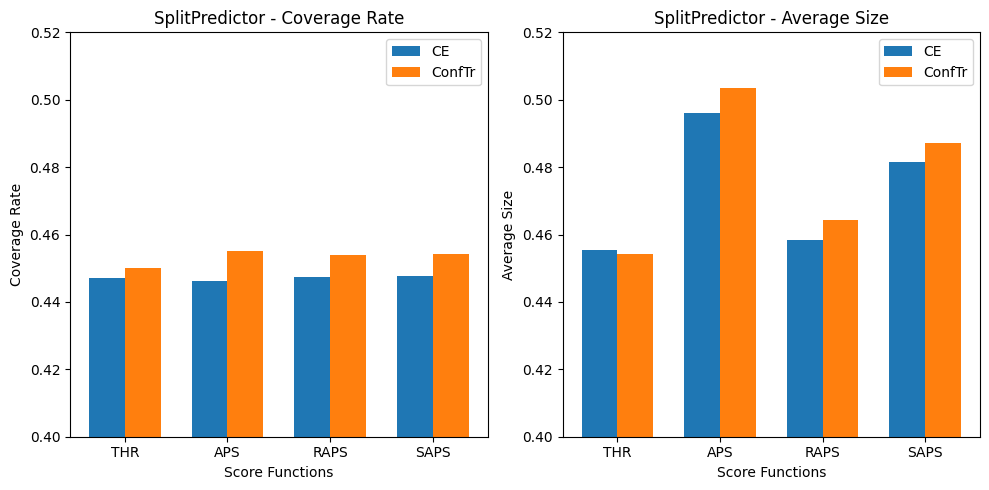

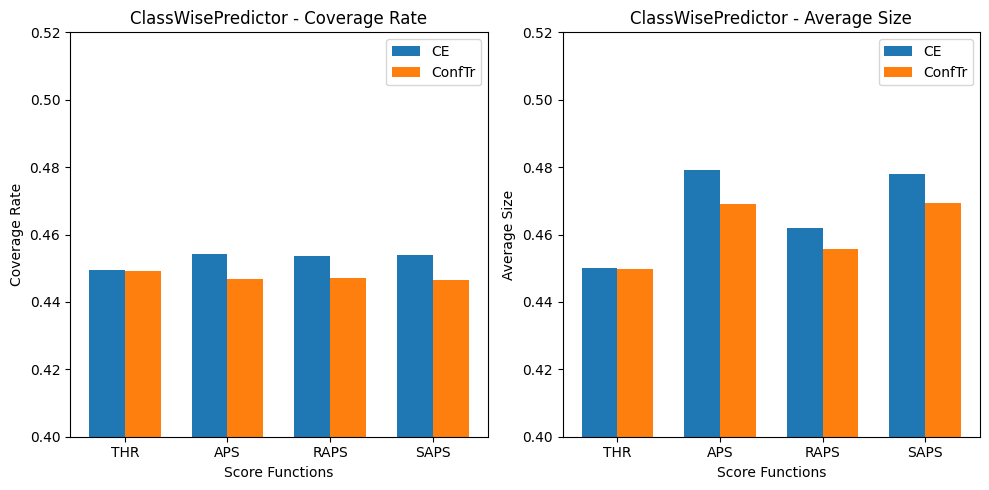

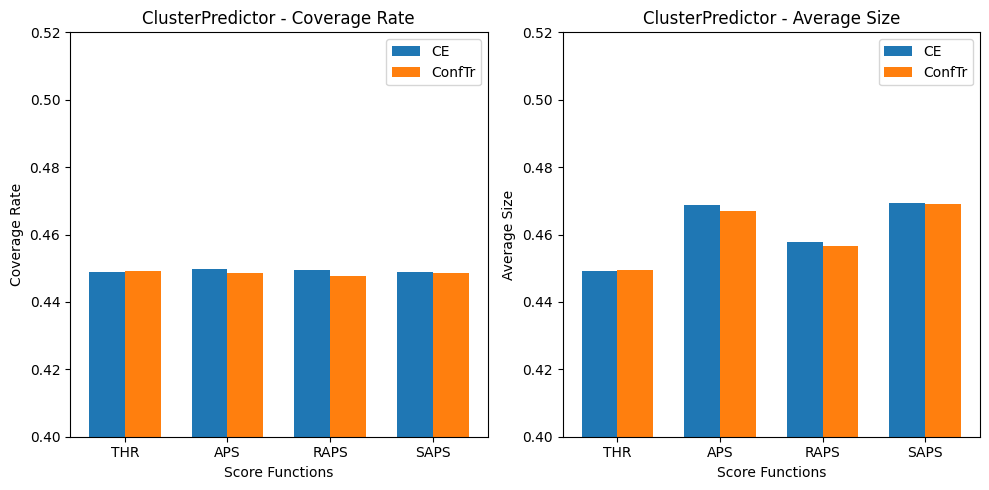

In [41]:
import matplotlib.pyplot as plt
import numpy as np

for predictor, predictor_data in data.items():
    data[predictor] = {score: value for score, value in predictor_data.items() if score != 'Margin'}

for predictor, predictor_data in data.items():
    score_functions = list(predictor_data.keys())
    bar_width = 0.35
    index = np.arange(len(score_functions))

    # 绘制覆盖率（Coverage Rate）柱状图
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.bar(index, [predictor_data[score]['CE']['Coverage_rate'] for score in score_functions], bar_width, label='CE')
    plt.bar(index + bar_width, [predictor_data[score]['ConfTr']['Coverage_rate'] for score in score_functions], bar_width, label='ConfTr')

    plt.xlabel('Score Functions')
    plt.ylabel('Coverage Rate')
    plt.ylim(0.4, 0.52)
    plt.title(f'{predictor} - Coverage Rate')
    plt.xticks(index + bar_width / 2, score_functions)
    plt.legend()
    plt.tight_layout()
    

    plt.subplot(1, 2, 2)
    plt.bar(index, [predictor_data[score]['CE']['Average_size'] for score in score_functions], bar_width, label='CE')
    plt.bar(index + bar_width, [predictor_data[score]['ConfTr']['Average_size'] for score in score_functions], bar_width, label='ConfTr')

    plt.xlabel('Score Functions')
    plt.ylabel('Average Size')
    plt.ylim(0.4, 0.52)
    plt.title(f'{predictor} - Average Size')
    plt.xticks(index + bar_width / 2, score_functions)
    plt.legend()

    plt.tight_layout()
    plt.show()
